# A/B Testing: What, Why, When, How
## What & Why
A/B Testing is a general framework of hypothesis testing between two groups to estiblish a causal relationship between actions and resutls, measure impact solely from the change.
## When
change UI design, user flow, add new features
algorithm enhancement, recommendation system, search ranking, ads display
define coupon value, promotion program
marketing optimization
search engine optimization (SEO)
campaign performance measurement
## How
1. design
- Understand problem & objectives
- come up with hypothesis
- design of experiment
2. Implement
- code change & testing
- run experiment & monitor
3. measurement
- result measurement
- data analysis
- decision making


# Mobile Game A/B Testing with Cookie Cats
## 1. Backgroud
Cookie Cats is a mobile puzzle game, a classic 'connect three' style puzzle game where palyer must connect tiles of the same color to clear the board and win the level. As a players progress throught the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make in-app purchase. In addition to driving in-app purchase, these gates also give players an enforced break from playing the game, therefore increase and prolong player's enjoryment.

Where should the gates be placed become important. Initially the first gate was placed at level 30, in this A/B testing we move gate to level 40, and look at the impact on player retention.

## 2. Design - understand problem & objectives
Change: moving the gate from level 30 to level 40
Goal: improve retention rate and conversion rate (in-purchase rate)

## 3. Design - hypothesis
Choose metrics: retention rate
Hypothesis: 
Null: p30 = p40
Alternative: p30 > p40

## 4. Implement - data preparation and description
### Data preparation
#### 4.1 Key assumptions
- the factor to test is the only reason for difference: test(A) and control(B)
- a unit been assigned to A or B is random
- each experiment unit are independent

A/A test can be used to check assumptions random and independent
A/A testing is the tactic of using A/B testing to test two identical versions of a page against each other. This is done to check that the tool being used to run the experiment is statistically fair. In an A/A test, the tool should report no difference in conversions between the control and variation, if the test is implemented correctly

#### 4.2 Assignment Units
Depends on the goal, user_id? Cookie_id? Device_id? Session_id? IP address?
Default is user_id, if there is no login user, then device_id or Cookie_id

Split % - % of users in test / control: usually 50% - 50%
due to time sensitive, eg. holiday marketing campaign

#### 4.3 Exposure & Duration
Don't show A/B versions to all users, it may lead to bad user experience if test version is bad

Minimum sample size:

$$n = \frac{2\sigma^2(Z_\beta+Z_{\alpha/2})^2}{difference^2}$$

Daily volume & exposure %
Seasonality, at least one season
Run at least 7 days

### Data preparation
The data is from 90,189 players that installed the game while the A/B test was running. When a player installed the game, he or she was randomly assigned to eith gate_30 or gate_40

- Userid - a unique number that identifies each player
- version - whether the player was put in the control group (gate_3o) or the group with the moved gate (gate_40)
- sun_gamerounds - the number of gam rounds played by the player during the first 14 days after installed
- retention_1 - did the player come back and play 1 day after installing
- retention_7 - did the player come back and play 7 days after installing 

In [1]:
# import dataset
import pandas as pd
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


#### Check Sanity
Let's see if there are rougthly the same number of palyers in each A/B group

In [2]:
# sanity check in each group
df.groupby(by='version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


It looks like there is roughly the same number of players in each group

Text(0, 0.5, '# of players')

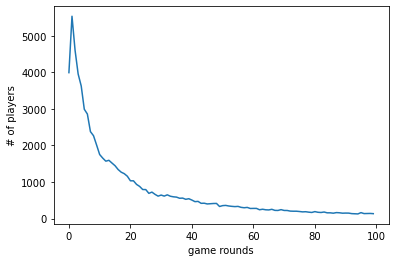

In [3]:
# Check distribution of gamerounds

%matplotlib inline

# count the number of players for each number of gamerounds
plot_df = df.groupby(by='sum_gamerounds').count()['userid']

# plot the distribution of players that played 0 to 100 game round
ax = plot_df.head(100).plot(x='sum_gamerounds', y='userid')
ax.set_xlabel('game rounds')
ax.set_ylabel('# of players')

Data is highly skewed and it's hard to approximate with CLT.

We can use Bootstrap - a resampling method with replacement. Same sample size as the original sample data.

## 5. Measurement - Result Measurement

In [4]:
# the % of users that came back 1 day after installing
df['retention_1'].mean()

0.4452095044850259

Overall 1-day retention rate is 0.4452

In [5]:
# calculate 1-day retention for each group
df.groupby(by='version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

1-day retention slightly decrease when the date was moved to level 40 (44.2%) compared to the control when it was at level 30 (44.8%)

In [6]:
# the % of users that came back 7 days after installing
df['retention_7'].mean()

0.1860648194347426

Overall 7-day retention rate is 0.1861

In [7]:
# calculate 7-day retention for each group
df.groupby(by='version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

7-day retention slightly decrease when the date was moved to level 40 (18.2%) compared to the control when it was at level 30 (19.0%)

## Method 1 - Bootstrap

We use bootstrapping, repeatedly re-sample our dataset with replacement, and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.

Text(0.5, 1.0, 'The Average of 1-Day Retention for each AB group')

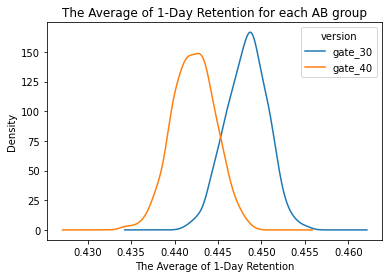

In [15]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
iterations = 500
for i in range(iterations):
    boot_mean = df.sample(frac=1,replace=True).groupby(by='version')['retention_1'].mean()
    boot_1d.append(boot_mean)    
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
  
ax = boot_1d.plot.kde()
ax.set_xlabel("The Average of 1-Day Retention")
ax.set_title("The Average of 1-Day Retention for each AB group")

The distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB grups. 

Let's zoom in on the difference in 1-day retention.

Text(0.5, 0, '% difference in 1-day retention rate between the two AB-groups')

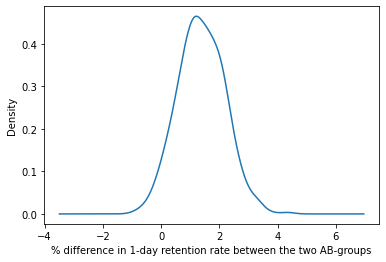

In [16]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d['gate_30']-boot_1d['gate_40'])/boot_1d['gate_40']*100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot.kde()
ax.set_xlabel('% difference in 1-day retention rate between the two AB-groups')

### The probability of a difference
From above chart, we can see that the more likely % difference is around 1% - 2%, and that most of the distribution is above 0%, in favor of a gate at level 30. 

But what is the probability that the differerence is above 0%?

In [11]:
# calculating the probability that 1-day retention is greater when the gate is at level 30
prob = (boot_1d['diff'] > 0).mean()

('{:.1%}').format(prob)

'96.4%'

### 7-day retention by AB group
Let's calculating 7-day retention for AB groups

In [12]:
# calculate 7-day retention for each group
df.groupby(by='version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

Like the 1-day retention, 7-day retention is slightly lower (18.2%) when the gate is at level 40 than when the gate is at level 30 (19.0%). This difference is also larger than for 1-day retention, presumably because more players have had time to hit the first gate. 

But as before, let's use bootstrap analysis to figure out how certain we should be of the difference between the AB groups

'84.8%'

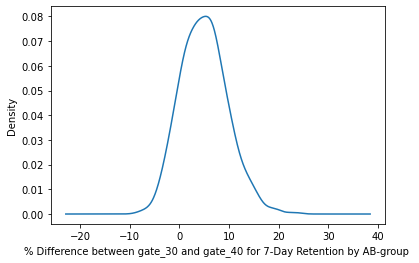

In [14]:
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=0.1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
boot_7d = pd.DataFrame(boot_7d)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)
ax = boot_7d['diff'].plot.kde()
ax.set_xlabel("% Difference between gate_30 and gate_40 for 7-Day Retention by AB-group ")
prob = (boot_7d['diff'] > 0).mean()
# Pretty printing the probability
('{:.1%}').format(prob)

## Method 2 -  p-value

In [18]:
N = df.groupby(by='version')['userid'].count()
X_1d = df.groupby(by=['version', 'retention_1'])['userid'].count()
X_7d = df.groupby(by=['version', 'retention_7'])['userid'].count()

print(N)
print(X_1d)
print(X_7d)

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64
version  retention_1
gate_30  False          24666
         True           20034
gate_40  False          25370
         True           20119
Name: userid, dtype: int64
version  retention_7
gate_30  False          36198
         True            8502
gate_40  False          37210
         True            8279
Name: userid, dtype: int64


1-day Retention:

n_1=44700 sample size for group gate_30

n_2=45489 sample size for group gate_40

x_1=20034 retention count for group gate_30

x_2=20119 retention count for group gate_40

7-day Retention:

n_1=44700 sample size for group gate_30

n_2=45489 sample size for group gate_40

x_1=8502 retention count for group gate_30

x_2=8279 retention count for group gate_40

$$Z_s tat = \frac{p1-p2}{\sqrt{p_{pooled}*(1-p_{pooled})*(\frac{1}{n_1}+\frac{1}{n_2})}}$$

### p-value for 1-day retention

In [20]:
import math
from scipy.stats import norm

n1 = 20034
n2 = 20119
p_pooled = (20034+20119)/(90189)
z_stat_1d = (0.448188-0.442283)/math.sqrt(p_pooled*(1-p_pooled)*(1/n1+1/n2))
print(z_stat_1d)

pvalue_1d = 1 - norm.cdf(z_stat_1d)
print(pvalue_1d)

1.190422735778533
0.11694014067197889


Since p-value is 0.1169 which is greater than 0.05, we reject the null hypothesis. There's enough evidence to suuport that 1-day retention rate for gate 30 is greater than for gate 40.

### p-value for 7-day retention

In [21]:
n1 = 8502
n2 = 8279
p_pooled = (8502+8279)/(90189)
z_stat_7d = (0.190201-0.182000)/math.sqrt(p_pooled*(1-p_pooled)*(1/n1+1/n2))
print(z_stat_7d)

pvalue_7d = 1 - norm.cdf(z_stat_7d)
print(pvalue_7d)

1.3648355992175636
0.08615236358155087


Since the p-value is 0.086 which is greater than 0.05, we also reject the null hypothesis. There is enough evidence to support that 7-day retention rate for gate 30 is greater than gate 40.

## Conclusion

Both the bootstrap and p-value result tell us that there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40. Our decision is **not** to move the gate from level 30 to level 40 if we want to keep retention high - both 1-day and 7-day retention.

There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are mode by the two AB groups. But retention is one of the most important metrics. If we don't retain our player base, it doesn't matter how much money they spend in-game.

Common sense is that the later the obstacle, the longer people are going to engage with the game. But this is not what the data tell us. Why?

In short, hedonic adaptation is the tendency for people to get less and less enjoyment out of a fun activity over time if that activity is undertaken continuously. By forcing players to take a break when they reach a gate, their enjoyment of the game is prolonger. But when the gate is move to level 40, fewer players make it far enough, and they are more likely to quit the game becasue they simply got bored of it.